In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

import gpflow
from gpflow.utilities import print_summary, positive

import tensorflow as tf
from tensorflow import math as tfm
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability import mcmc

from load_puma_data import load_barenco_puma
import math
import random

PI = tf.constant(math.pi, dtype='float64')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df, genes, genes_se, Y, Y_var = load_barenco_puma()


N_m = 7               # Number of observations
def calc_N_p(N_p, num_disc=8):
    '''A helper recursive function to ensure t is a subset of τ'''
    if num_disc <= 0:
        return N_p
    return N_p -1 + calc_N_p(N_p, num_disc-1)
num_disc = 10
N_p = calc_N_p(N_m, num_disc)  # Number of time discretisations
t = np.arange(N_m)*2           # Observation times
τ = np.linspace(0, 12, N_p, dtype='float32')    # Discretised observation times
num_genes = 5
I = 1 # Number of TFs

m_observed = np.float32(Y[:-1])
f_observed = np.float32(np.atleast_2d(Y[-1]))
σ2 = np.float32(Y_var[:-1])
σ2_f = np.float32(np.atleast_2d(Y_var[-1]))

## Metropolis Hastings Custom MCMC Algorithm

In [3]:
# Parameters
w_j0 = 1    # Interaction bias (TODO)
fbar_i = 0.5*np.ones(N_p, dtype='float32')
v_i = 1 # Fix this to 1 if translation model is not used (pg.8)
l2_i = 0.1
δbar_i = np.float32(1)
h_δ = 1
h_c = 0.5
h_f = tf.ones(N_p, dtype='float32')
h_k = tf.ones(4, dtype='float32')
h_w = tf.ones(num_genes, dtype='float32')
h_σm = 1.2*tf.ones(num_genes, dtype='float32')
a = tf.constant(-0.5, dtype='float32')
b2 = tf.constant(2., dtype='float32')
w_j = 0.5*np.ones((num_genes, I))
σ_m2 = np.ones(num_genes, dtype='float32')
kbar_i = np.float32(np.c_[np.ones(num_genes), # a_j
                          np.ones(num_genes), # b_j
                          np.ones(num_genes), # d_j
                          np.ones(num_genes)])# s_j
def fixed(kbar, gene):
    if gene == 3:
        kbar[2] = np.log(0.8)
        kbar[3] = np.log(1.0)
    return kbar
kbar_i[3] = fixed(kbar_i[3], 3)


In [4]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

# Priors
def l2_prior(l2):
    return tfd.Uniform(0.01, 1).prob(l2) # TODO
def v_prior(v):
    return 1
def σ_m2_prior(σ):
    return tfd.InverseGamma(0.01, 0.01).prob(σ)

def w_j_prior(w_j): # At the moment this is the same as w_j0 (see pg.8)
    return tfd.Normal(0, 2).prob(w_j0)
def w_j0_prior(w_j0):
    return tfd.Normal(0, 2).prob(w_j0)
    
def kbar_prior(kbar):
    return np.prod(tfd.Normal(a, b2).prob(kbar))

def fbar_prior_params(v=v_i, l2=l2_i):
    t_1 = np.reshape(np.tile(τ, N_p), [N_p, N_p]).T
    t_2 = np.reshape(np.tile(τ, N_p), [N_p, N_p])
    t_dist = t_1-t_2
#     print('vl2', v, l2)
    jitter = tf.linalg.diag(1e-5 * np.ones(N_p, dtype='float32'))
    K = v * np.exp(-np.square(t_dist)/(2*l2)) + jitter
    m = np.zeros(N_p, dtype='float32')
    return m, K

def fbar_prior(fbar, v=v_i, l2=l2_i):
    m, K = fbar_prior_params(v, l2)
    try:
        prob = np.float64(tfd.MultivariateNormalFullCovariance(m, K).prob(fbar))
        return prob
    except:
        jitter = tf.linalg.diag(1e-4 * np.ones(N_p, dtype='float32'))
        try:
            prob = np.float64(tfd.MultivariateNormalFullCovariance(m, K+jitter).prob(fbar))
            return prob
        except:
            return 0

def δbar_prior(δ):
    return np.float64(tfd.Normal(a, b2).prob(δ))

# Likelihood
def G(n, k, p_i, d_j, w):
    # TODO add binary vector x_j for prior network knowledge (pg.3)
    numerator = np.exp(-d_j*(t[n]-τ[k]))
    denominator = (1+np.exp(-w_j0-sum([w[:,i]*np.log(p_i[k]) for i in range(I)])))
    return numerator/denominator

def m_likelihood(δbar=δbar_i, 
                 fbar=fbar_i, 
                 kbar=kbar_i, 
                 w=w_j,
                 σ_m2=σ_m2, for_gene_only=False):        
    # Take relevant parameters out of log-space
    δ = np.exp(δbar)
    f_i = np.exp(fbar)
    a_j, b_j, d_j, s_j = (np.exp(kbar_i[:, i]) for i in range(4)) 
#     print('exped', δ)
    # Define p_i vector
    p_i = np.zeros(N_p)
    for n in range(N_p):
        N_pn = n#n*10+n
        p_i[n] = np.trapz([f_i[k] * np.exp(-δ*(τ[n]-τ[k])) for k in range(N_pn)], τ[:N_pn])
#     print('pi', p_i)
    
    # Calculate m_pred
    m_pred = np.zeros((num_genes, N_m), dtype='float32')

    for n in range(N_m):
        N_pn = n*10+n
        ys =  np.array([G(n, k, p_i, d_j, w) for k in range(N_pn)])
        if ys.shape[0] == 0:
            ys = np.zeros((0, num_genes))
        integrals = np.array([np.trapz(ys[:, i], τ[:N_pn]) for i in range(num_genes)])
#         print('integrals', integrals)
#         print( np.exp(-d_j*t[n]))
        m_pred[:, n] = b_j/d_j + (a_j-b_j/d_j)* np.exp(-d_j*t[n]) + s_j*integrals

#     print(m_pred, m_observed.shape)
    lik = 1    
    if for_gene_only is False:
        for j in range(num_genes):
            prob = tfd.Normal(m_observed[j], σ2[j]+σ_m2[j]).prob(m_pred[j])
            lik *= tf.reduce_prod(prob)
    else:
        j = for_gene_only
        prob = tfd.Normal(m_observed[j], σ2[j]+σ_m2[j]).prob(m_pred[j])
        lik *= tf.reduce_prod(prob)
    return lik

def f_likelihood(fbar, i=0): 
    '''TODO this should be for the i-th TF'''
    f_i = np.exp(fbar)
    f_i = np.float32(np.atleast_2d([f_i[i*num_disc+i] for i in range(N_m)]))
#     print(f_i[i], f[i])
    prob = tfd.Normal(f_observed[i], σ2_f[i]).prob(f_i[i])
#     print('prob', prob)
    lik = tf.reduce_prod(prob)
    return lik


----- Metropolis Begins -----


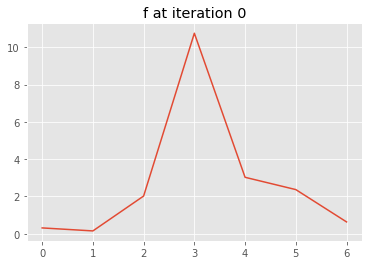

c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in less


In [ ]:
print('----- Metropolis Begins -----')

params = {'δ': list(), 
          'k': [list() for _ in range(num_genes)],
          'σ': [list() for _ in range(num_genes)],
          'w': [list() for _ in range(num_genes)],
          'L': list(),
          'V': list()
         }
T = 3000


h_f =0.4*tf.ones(N_p, dtype='float32')

for iteration_number in range(T):
    if iteration_number % 100 == 0:
        print(f'{100*iteration_number/T:.2f}% complete', end='\r')
    if iteration_number % 500 == 0:
        f_plot = np.exp(fbar_i)
        f_plot = [f_plot[i*num_disc+i] for i in range(N_m)]
        plt.figure(figsize=(4, 4))
        plt.plot(f_plot)
        plt.title(f'f at iteration {iteration_number}')
        plt.show()

    # Untransformed tf mRNA vectors F
    for i in range(I):
        # Gibbs step
        z_i = tfd.MultivariateNormalDiag(fbar_i, h_f).sample()
        # MH
        m, K = fbar_prior_params()
        fstar = tfd.MultivariateNormalFullCovariance(m, K).sample()
        fstar = tfd.MultivariateNormalDiag(fstar, h_f).sample()
        g = lambda fbar: m_likelihood(fbar=fbar) * f_likelihood(fbar)
        acceptance = g(fstar)/g(fbar_i)
        if random.random() < min(1, acceptance):
            fbar_i = fstar

    # Log of translation ODE degradation rates
    for i in range(I):
        # Proposal distribution
        Q = tfd.Normal(δbar_i, h_δ)
        δstar = Q.sample() # δstar is in log-space, i.e. δstar = δbar*
        g = lambda δbar: m_likelihood(δbar=δbar) * δbar_prior(δbar)
        acceptance = min(1, g(δstar)/g(δbar_i))
        if random.random() < acceptance:
            δbar_i = δstar
            params['δ'].append(δstar)
            
    # Log of transcription ODE kinetic params
    for j in range(num_genes):
        Q = tfd.MultivariateNormalDiag(kbar_i[j], h_k)
        kstar = Q.sample().numpy()
        kstar = fixed(kstar, j)
        g = lambda kbar: m_likelihood(kbar=kbar, for_gene_only=j) * kbar_prior(kbar)
        acceptance = min(1, g(kstar)/g(kbar_i[j]))
        if random.random() < acceptance:
            kbar_i[j] = kstar
            params['k'][j].append(kstar)

    # Interaction weights and biases
    for j in range(num_genes):
        Q = tfd.Normal(w_j[j], 0.1)#h_w[j])
        wstar = Q.sample()[0]
        g = lambda w: m_likelihood(for_gene_only=j) * w_j_prior(w)
#         print('----')
#         print(g(wstar))
#         print(g(w_j[j][0]))
        acceptance = min(1, g(wstar)/g(w_j[j][0]))
#         print('accept', acceptance)
        if random.random() < acceptance:
            w_j[j] = wstar
            params['w'][j].append(wstar)

    # Noise variances (this doesn't use a loop over j, TODO: change other subroutines to similar)
    Q = lambda σ: tfd.TruncatedNormal(σ, h_σm, low=0, high=100)
    σ_m2star = Q(σ_m2).sample()
    g = lambda σ, σ_other: m_likelihood(σ_m2=σ, for_gene_only=j) * σ_m2_prior(σ) * Q(σ).prob(σ_other)
    acceptance = np.random.random(num_genes) < np.minimum(
        np.ones(num_genes), g(σ_m2star, σ_m2) / g(σ_m2, σ_m2star))
    for j in range(num_genes):
        if acceptance[j]:
            σ_m2[j] = σ_m2star[j]
            params['σ'][j].append(σ_m2star[j])

    # Length scales and variances of GP kernels
    for i in range(I):
        Q_v = lambda v: tfd.TruncatedNormal(v, l2_i, low=0, high=100)
        Q_l = lambda l2: tfd.TruncatedNormal(l2, h_c, low=0, high=100)
        vstar = Q_v(v_i).sample()
        l2star = Q_l(l2_i).sample()
#         print(l2star, 'prior', fbar_prior(fbar_i, vstar, l2star))
        g = lambda v, l2, v_other, l2_other: fbar_prior(fbar_i, v, l2) * \
            v_prior(v) * l2_prior(l2) * Q_v(v_other).prob(v) * Q_l(l2_other).prob(l2)
#         print(g(v_i, l2_i, vstar, l2star))
        acceptance = g(vstar, l2star, v_i, l2_i) / g(v_i, l2_i, vstar, l2star)
#         print(acceptance)
        if random.random() < min(1, acceptance):
            v_i = vstar
            l2_i = l2star
            params['V'].append(vstar)
            params['L'].append(l2star)

print('----- Finished -----')


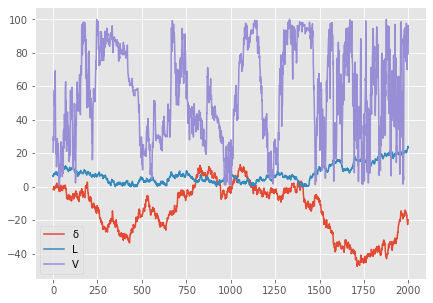

In [149]:
# Plot decay
plt.figure(figsize=(7, 5))
for param in ['δ', 'L', 'V']:
    plt.plot(params[param], label=param)
plt.legend()
#'σ', 'w']):


(1770, 4)
(1963, 4)
(2000, 4)
(1702, 4)
(1926, 4)


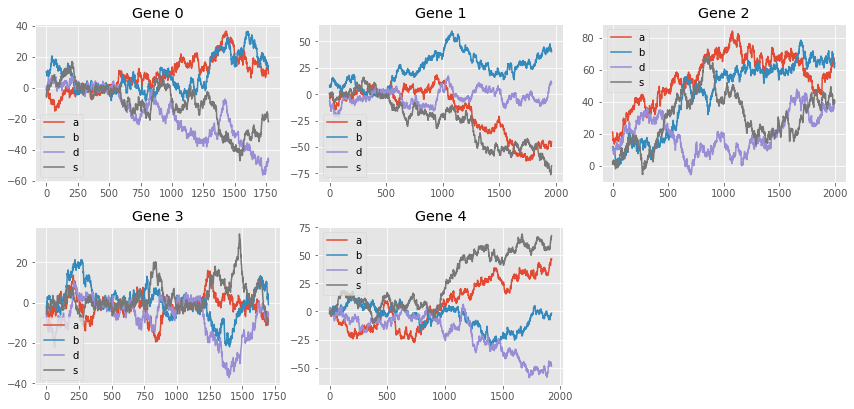

In [169]:
# Plot transcription ODE kinetic params
plt.figure(figsize=(12, 14))
plt.title('Transcription ODE kinetic parameters')
labels = ['a', 'b', 'd', 's']
for i, j in enumerate(range(num_genes)):
    ax = plt.subplot(num_genes, num_genes-2, i+1)
    k_param = np.array(params['k'][j])
    print(k_param.shape)
    
    for k in range(4):
        plt.plot(k_param[:, k], label=labels[k])
    plt.legend()
    ax.set_title(f'Gene {j}')

plt.tight_layout()
plt.figure()


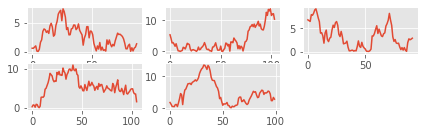

In [167]:
plt.figure(figsize=(7, 5))
plt.title('Noise variances')
for i, j in enumerate(range(num_genes)):
    ax = plt.subplot(num_genes, num_genes-2, i+1)
    plt.plot(params['σ'][j]);

[0.13922934, 0.004228441, 0.00018148805, 7.0737224e-05, 0.0034015367, 0.025193121, 0.072012134]


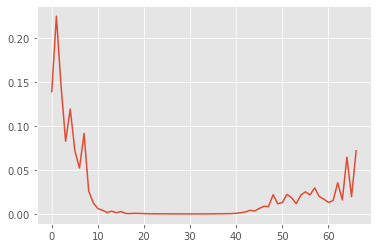

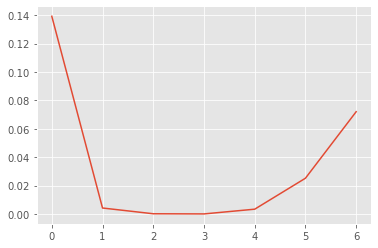

In [170]:
f_i = np.exp(fbar_i)
plt.plot(f_i)
plt.figure()
f_i = [f_i[i*num_disc+i] for i in range(N_m)]
print(f_i)
plt.plot(f_i)
